 Exercise Sheet No. 6

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 31.05.2021, 8 am
>
> Tutor: Matthias Schniewind [matthias.schniewind@kit.edu](mailto:matthias.schniewind@kit.edu)  
> **Please ask questions in the forum and only contact the tutor for issues regarding the grading**

---

**Topic**: This exercise sheet will focus on feed-forward neural networks, their implementation and training, as well as an application to materials science.

**You have two weeks to finish for Pentecost (Pfingst) holidays :)**

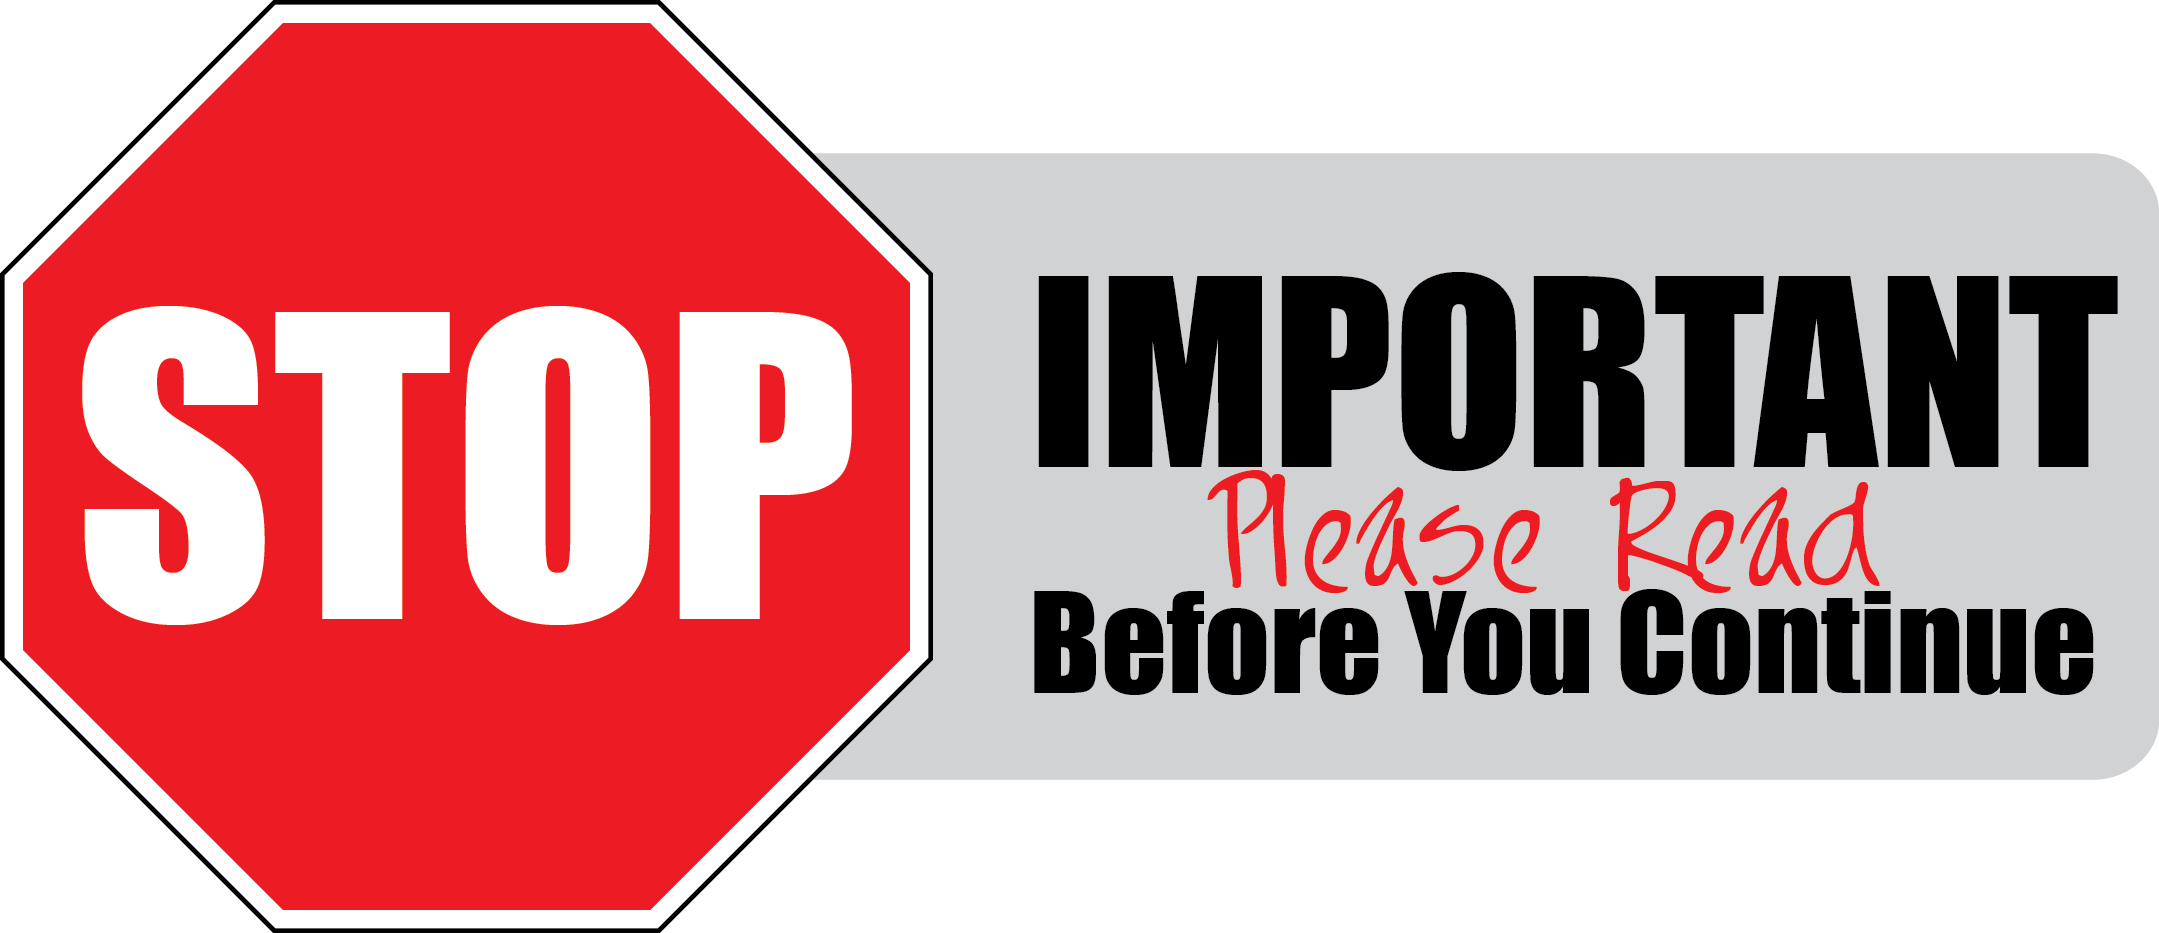

# Preliminaries

As we had problems with the nbgrader versions, **everyone needs to rebuild their environment**. When downloading the assignment you were provided with an environment.yml file.  
Please shutdown jupyter and run on the command line / anaconda prompt using the new environment file:
```
# Deactivate aimat
conda deactivate aimat

# Remove aimat
conda env remove -n aimat

# Rebuild the conda environment. From here it is all the initial setup:
conda env create -f environment.yml

# add nbgrader extensions needed to validate your results locally
conda run -n aimat jupyter nbextension install --sys-prefix --py nbgrader --overwrite
conda run -n aimat jupyter nbextension enable --sys-prefix --py nbgrader
conda run -n aimat jupyter serverextension enable --sys-prefix --py nbgrader

# activate the conda environment, otherwise, your previously installed
# packages won't be accessible
conda activate aimat

# Start jupyter again
jupyter notebook Exercise06.ipynb
```

# General remarks

We do our best to provide you with interesting, as well as challenging exercises. Many of you submit high quality notebooks and also start playing around with the existing code to go further. We like to see that and strongly encourage you to go beyond what is covered in the exercises if time and motivation allows.  

**Nevertheless, it makes your life and our life much easier if you use another copy of the notebook as playground and try to stay as concise as possible in the submitted notebooks.** We are a small team and it is impossible to check all the exercise sheets manually. Therefore when things fail because you did additional things in the notebooks, we won't see that in the first run and it is quite some effort to debug this. So please don't add additional cells or delete cells in you submission.

---

# Application

Next week you will start learning about applications of NNs in materials science. To give you a little teaser, we will use an application in materials science already here:

# Organic Solar Cells
For organic materials to become semi-conducting, electrons must be delocalized in the molecule. For electrons to be delocalized, a high level of conjugation is necessary:  
When single and double bonds are alternating in an organic molecule, electrons can move. When we think about an aromatic ring, like benzene, it is not defined where the double bonds would form, so they can move around the ring and are delocalized along the whole aromatic system:

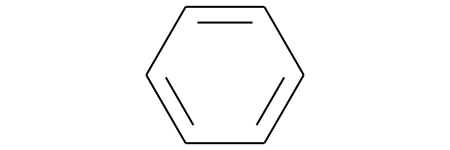

In [1]:
from rdkit import Chem

mol = Chem.MolFromSmiles('c1ccccc1')
mol

These electrons have higher energies and are part of what is called the highest occupied molecular orbit (HOMO). This is basically the equivalent of the valence band in classical semiconductors.  

The equivalent of the conduction band is the lowest level at higher energies that is unoccupied or the lowest unoccupied molecular orbit (LUMO). The gap between those two levels is the bandgap of organic semiconductors.

For OPV (organic photovoltaic) solar cells this bandgap needs to be small enough so that visible light can excite an electron from the HOMO to the LUMO. This requires a high level of conjugation and hence aromatic systems (Figure 1)

<a title="Alevina89, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Homo-lumo_gap.tif"><img width="512" alt="Homo-lumo gap" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Homo-lumo_gap.tif/lossless-page1-607px-Homo-lumo_gap.tif.png"></a>
<p style="text-align:center;font-size:80%;font-style:italic">
    Figure 1: Conjugation induced LUMO reduction.
</p>

For the development of organic semiconductors, HOMO and LUMO can be simulated by density functional theory (DFT) using different levels of theory. You will learn about this in later lectures. All you need to know now, is that depending on the level of theory  - or better the details of the approximations taken - the calculation of properties like HOMO and LUMO from the molecule can take hours.

This is a problem for high-throughput screening if one wants to discover new materials. It is extremely costly to evaluate e.g. 100,000 molecules for their properties with methods that are precise enough. Hence, one usually tries to do a detailed simulation only on a subset of molecules and then train a ML-model to predict the properties of interest on the labeled data.

## Dataset
The dataset of [Lopez et Al. 2017](https://www.sciencedirect.com/science/article/pii/S2542435117301307) contains the simulated LUMO and HOMO values for 51,247 organic molecules. Additionally, it contains 63 molecule descriptors that were calculated using [rdkit](https://www.rdkit.org/docs/index.html):

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_hdf('OPV.h5')
df.describe()

labels               mol_descriptors                \
               LUMO          HOMO   NumHAcceptors    NumHDonors   
count  51247.000000  51247.000000    51247.000000  51247.000000   
mean      -3.469117     -6.278187        9.479892      0.434699   
std        0.556705      0.586477        2.439179      0.773003   
min       -5.785082     -8.829189        0.000000      0.000000   
25%       -3.879740     -6.699339        8.000000      0.000000   
50%       -3.480653     -6.319910        9.000000      0.000000   
75%       -3.069627     -5.820485       11.000000      1.000000   
max       -1.577372     -4.088010       23.000000      6.000000   

                                                                      \
      NumHeteroatoms NumValenceElectrons  fr_thiophene     PEOE_VSA5   
count   51247.000000        51247.000000  51247.000000  51247.000000   
mean       11.535895          176.291646      1.188674     18.012681   
std         2.727198           29.118399      1.147485     16.466421   
min         0.000000           54.000000      0.000000      0.000000   
25%         9.000000          160.000000      0.000000      0.000000   
50%        12.000000          180.000000      1.000000     11.336786   
75%        13.000000          196.000000      2.000000     23.098671   
max        28.000000          318.000000      9.000000    124.704645   

                                   ...                                \
          PEOE_VSA6     PEOE_VSA7  ... HeavyAtomCount HeavyAtomMolWt   
count  51247.000000  51247.000000  ...   51247.000000   51247.000000   
mean      14.876386     29.051809  ...      36.115675     502.741343   
std       21.106906     16.974289  ...       6.068335      81.664870   
min        0.000000      0.000000  ...      11.000000     146.085000   
25%        0.000000     17.696186  ...      32.000000     458.376000   
50%        6.076020     28.832742  ...      37.000000     516.482000   
75%       23.523770     40.041517  ...      40.000000     558.416000   
max      169.858278    136.508949  ...      66.000000     902.998000   

                                                                    \
           fr_imide     LabuteASA MaxAbsEStateIndex MaxEStateIndex   
count  51247.000000  51247.000000      51247.000000   51247.000000   
mean       0.533202    211.089329         12.268723      12.268722   
std        0.882705     35.016824          2.787968       2.787973   
min        0.000000     61.168567          2.188704       2.188704   
25%        0.000000    190.573070         11.637669      11.637669   
50%        0.000000    215.878722         13.047850      13.047850   
75%        1.000000    234.220092         13.919575      13.919575   
max        6.000000    380.808169         17.589617      17.589617   

                                                               
         fr_nitrile         MolWt     NHOHCount       NOCount  
count  51247.000000  51247.000000  51247.000000  51247.000000  
mean       0.848284    516.483676      0.463617      8.701622  
std        1.286705     83.755283      0.865545      2.913345  
min        0.000000    149.109000      0.000000      0.000000  
25%        0.000000    470.446000      0.000000      6.000000  
50%        0.000000    530.613000      0.000000      9.000000  
75%        2.000000    573.685000      1.000000     11.000000  
max       11.000000    904.006000      8.000000     24.000000  

[8 rows x 65 columns]

The dataframe has a two-level column index so you can index the labels by calling `df['labels']`:

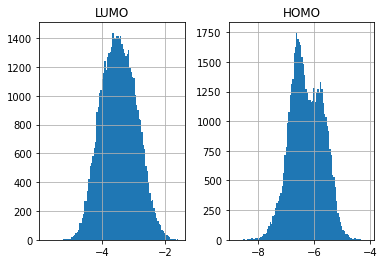

In [3]:
df['labels'].hist(bins=100)
plt.show()

# Linear regression benchmark
For a first shot we can train a ridge regression to predict the `labels` from the `mol_descriptors`.

This time we will use `sklearn`. Additionally we will also pre-process the features with a standard scaler to shift them to zero mean and scale them to unit variance.

As already mentioned, the calculation of DFT properties can be very costly. Hence, we want to have a model that extrapolates well to unseen data. Hence, we will use only 20% of the dataset for training and test on 80%.



In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df['mol_descriptors'].values
y = df['labels'].values

First use the [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the features (`X`) to mean of 0 and unit variance:

In [5]:
# Assign a StandardScaler object to scaler and obtain the scaled fatures as X_scaled
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# YOUR CODE HERE
# raise NotImplementedError()

In [6]:
# Scaler - 1 point

assert isinstance(scaler, StandardScaler), "The scaler should be an instance of the sklearn StandardScaler"
np.testing.assert_almost_equal(np.mean(X_scaled), 0, 10)
np.testing.assert_almost_equal(np.var(X_scaled, axis=0).sum(), 63.)
# Possible hidden tests

Next we use the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) to split of 20% of `X_scaled` and `y` as train set and use the rest as test set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=0)

Now use the [`Ridge()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge) model to fit a ridge regression with standard parameters to the train data, and assign the predictions of the fitted model on the test data to `y_pred`:

In [8]:
# Instantiate a Ridge() model as model, fit it and assign the predictions to y_pred
model = Ridge()
y_pred = model.fit(X_train, y_train).predict(X_test)

# YOUR CODE HERE
# raise NotImplementedError()

In [9]:
r2_lumo_ridge = r2_score(y_test[:,0], y_pred[:,0])
r2_homo_ridge = r2_score(y_test[:,1], y_pred[:,1])
print(f'R2 LUMO: {r2_lumo_ridge}\nR2 HOMO: {r2_homo_ridge}')

R2 LUMO: 0.716582985383903
R2 HOMO: 0.7971295175598255


In [10]:
# Ridge Regression - 1 point

assert y_pred.shape[0] == y_test.shape[0]
assert y_pred.shape[1] == y_test.shape[1]
assert r2_lumo_ridge > 0.70
assert r2_homo_ridge > 0.78
# Possible hidden tests

Now we can plot the correlations of the the true and predicted values:

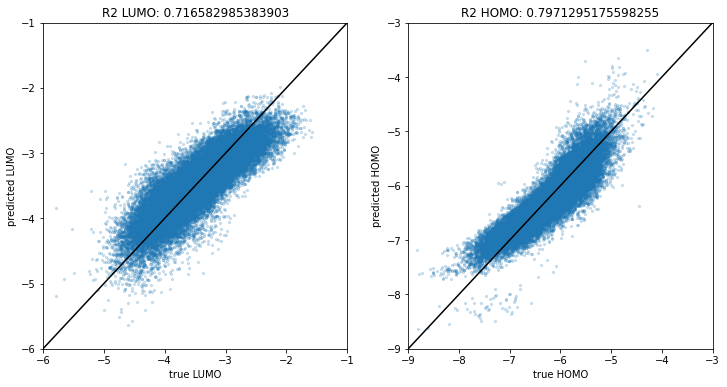

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].scatter(y_test[:,0], y_pred[:,0], alpha=0.2, s=5)
axs[0].plot([-6, -1], [-6, -1], 'k')
axs[0].set_title(f'R2 LUMO: {r2_lumo_ridge}')
axs[0].set_xlabel('true LUMO')
axs[0].set_ylabel('predicted LUMO')
axs[0].set_xlim([-6, -1])
axs[0].set_ylim([-6, -1])

axs[1].scatter(y_test[:,1], y_pred[:,1], alpha=0.2, s=5)
axs[1].plot([-9, -3], [-9, -3], 'k')
axs[1].set_title(f'R2 HOMO: {r2_homo_ridge}')
axs[1].set_xlabel('true HOMO')
axs[1].set_ylabel('predicted HOMO')
axs[1].set_xlim([-9, -3])
axs[1].set_ylim([-9, -3])

plt.show()

As you can see, the ridge regression learns something, but the predictions are still way off from the true values.

Hence, we will apply a non-linear model, namely a:

# Neural Network

## A little bit of biology background

The rough idea of todays neural networks stems from biological neural networks. A neuron, integrates information from its upstream neurons at the dendrites, creating a post-synaptic potential. At the axon hillock this potential is encoded into a spike train of action potentials. These are sent down he axon until they reach a synapse of an axon terminal. At the synapse the spike train is again decoded into a pre-synaptic potential and depending on the incoming spike frequency more or less neurotransmitters are released to pass the signal on to the next neuron (Figure 2).
<p style="text-align:center;font-size:80%;font-style:italic">
    <img src="https://recurrence-reviewed.de/content/images/2019/04/Neuron2.png", width="50%">
    <br>
    Figure 2: Simplified sketch of a neuron.
</p>


## Forward Pass

For todays artificial neural networks this was simplified in the following way:  
Instead of simulating spikes, we only simulate a spike frequency as a continuous value. Depending on the post-synaptic potential, this frequency can be higher or lower. E.g. neurons do not respond at all until a specific post-synaptic potential is reached and also have a maximum spike-frequency. This implies two things:  
**1. The transformation from post-synaptic potential to spike-frequency is non-linear. (activation function)**  
**2. Each neuron has a different base activity. (bias)**

In the following mathematical definitions, lower-case letters denote scalars, while upper-case letters denote vectors or matrices. No dot or $\cdot$ denotes a dot product of vectors or matrices.

### Single neuron
Given a subjected neuron $l$ receives inputs from an upstream layer $k$ and the upstream layer consists of three neurons with the outputs $x_1, x_2, x_3$ via connections with weights $\theta_{1,l}, \theta_{2,l}, \theta_{3,l}$ (Figure 3), we can compute the weighted sum as state $h_l(X)$ of the subjected neuron by linear algebra as the product of the row vector $X_k$ and the column vector $\Theta_{k,l}$. Additionally, we add a bias $b$ to the neuron.

\begin{align}
h_l(X) &= X_k \cdot \Theta_{k,l} + b_l\\
&=
\begin{bmatrix}
    x_1 & x_2 & x_3
\end{bmatrix} 
\cdot
\begin{bmatrix}
    \theta_{1,l} \\ \theta_{2,l} \\ \theta_{3,l}
\end{bmatrix}
+ b_l\\
&=x_1 \theta_{1,l} +  x_2 \theta_{2,l} + x_3 \theta_{3,l} + b_l
\end{align}

And the output or activation $a_l(x)$ of the subjected neuron in terms of spike-frequency is computed using a non-linear activation function $\sigma()$:

\begin{align}
a_l(X) &= \sigma(h_l(X))
\end{align}

<div>
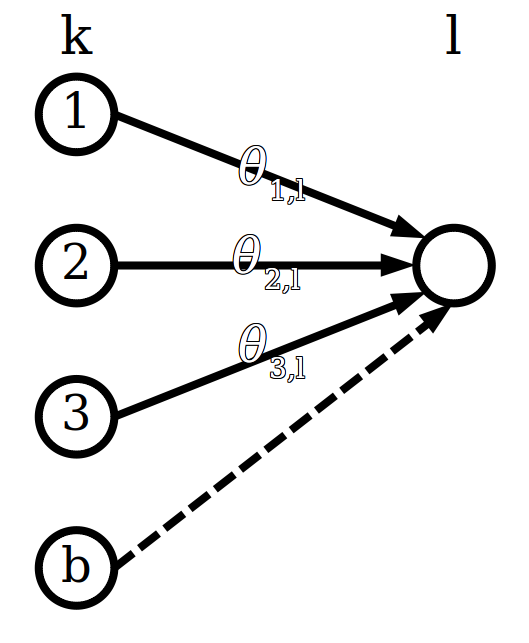
</div>
<p style="text-align:center;font-size:80%;font-style:italic">
Figure 3: A neuron layer k with three neurons has feed-forward connections to a single neuron l.
</p>

### Neuron Layer
Now given that the subjected $l$ is not only a single neuron but e.g. a layer of two neurons (Figure 4), the notation is the same with the only difference that we add a column to the weight column vector $\Theta_{k,l}$ changing it to a $3 \times 2$ dimensional matrix to calculate the $1 \times 2$ dimensional row state vector $H_l(X)$:

\begin{align}
    H_l(X) &= X_k \cdot \Theta_{k,l} + B_l\\
    &=
    \begin{bmatrix}
        x_1 & x_2 & x_3
    \end{bmatrix} 
    \cdot
    \begin{bmatrix}
        \theta_{1,1} & \theta_{1,2} \\
        \theta_{2,1} & \theta_{2,2} \\
        \theta_{3,1} & \theta_{3,2} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        b_1 & b_2 
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
        \theta_{1,1} x_1 + \theta_{1,2} x_2 + \theta_{1,3} x_3 + b_1 &
        \theta_{2,1} x_1 + \theta_{2,2} x_2 + \theta_{2,3} x_3 + b_2
    \end{bmatrix}
\end{align}

And the activation of the layer:

\begin{align}
A_i(X) &= \sigma(H_i(X))
\end{align}

<div>
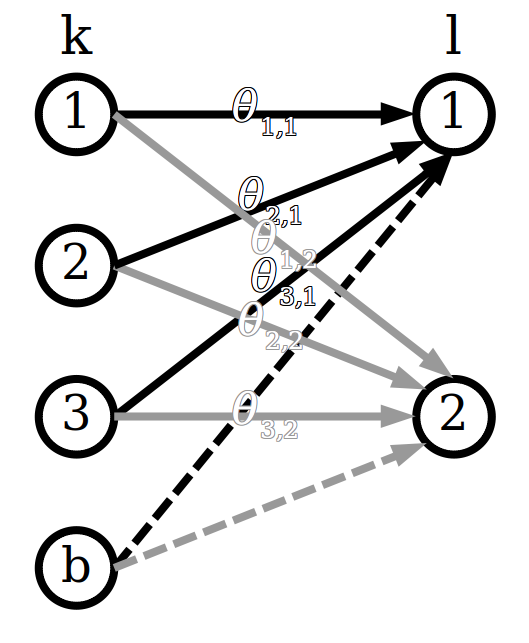
</div>
<p style="text-align:center;font-size:80%;font-style:italic">
Figure 4: A neuron layer j with three neurons has feed-forward connections to a neuron layer i with two neurons.
</p>

For the bias there exist two approaches:
1. One can see the bias as an additional input with a constant $1$ from the previous layer and a learnable weight vector.
2. Adding the bias simply as row vector that added to the neuron state $H(x)$.

Here we use approach 2.

### Batches
Usually data is processed in batches, so not only one single sample is processed at a time but multiple samples as this is much faster when calculated using vectorization. In our case, samples are rows with the length of the features. So when we pass 10 samples of our features (the `mol_descriptors`), we pass a matrix of shape $10 \times 63$. This already fits well with our current notation. E.g. if we use a hidden layer with $32$ neurons and input our features it will return a $10 \times 32$ state matrix.


### Weight initialization
To compute anything, the weights must be different from $0$. There are several approaches to initialize weights. We will use the approach of [Glorot et Al., 2010](http://proceedings.mlr.press/v9/glorot10a.html).
The initial weights are drawn form a uniform distribution $U(-z, z)$ with the limit $z$ calculated as:
\begin{align}
    z &= \sqrt{\frac{6}{k+l}}
\end{align}
...with input length $k$ and output length $l$.


Just to get an idea how this all works in python we will build a layer with 32 neurons and feed all 63 `mol_descriptors`.  
Initialize the weight matrix `theta` using numpy functions:

In [12]:
# Take 10 rows as one batch
sample = X_train[0:10]
n_inputs = sample.shape[1]
n_outputs = 32

In [13]:
# Initialize the weights theta after Glorot et Al. 2010 (glorot uniform):
z = np.sqrt(6/(n_inputs + n_outputs))
theta = np.random.uniform(-z, z, (n_inputs, n_outputs))
# YOUR CODE HERE
# raise NotImplementedError()

In [14]:
# Weights - 1 point

assert theta.shape[0] == n_inputs, "Your weight shape doesn't match!"
assert theta.shape[1] == n_outputs, "Your weight shape doesn't match!"

# Hidden asserts for the limits of the uniform distribution

Now calculate h(x) for the sample using your weights:

In [15]:
# Initialize the bias row vector with zeros:
b = None 
# YOUR CODE HERE
b = np.zeros((n_outputs,))

# Calculate h(x) using sample, theta and b
# The bias won't change anything but it will check for correct shapes.
h = None
# YOUR CODE HERE
h = (sample @ theta) + b

In [16]:
# States - 2 points

assert h.shape[0] == sample.shape[0]
assert h.shape[1] == n_outputs
# Possible hidden asserts

## Activation functions

Our model will be a regression model. For the output of the model we need to fit the unscaled `y`. Hence we need an unbound linear activation function for the output, which is basically an identity function:

\begin{align}
    linear(H(x)) &= H(x)
\end{align}

As non-linear activation function for the hidden layers we will use the ReLu function:

\begin{align}
    relu(H(x)) &= 
\begin{cases} 
    0~\text{ if }~h_l(x) \leq 0\\
    h_l(x)~\text{ if }~h_l(x)>0
\end{cases}
\end{align}

So it sets all values below zero to zero.  
The ReLu has the biological motivation of having a minimal threshold until it starts outputting values different from 0. Additionally, it yields sparse activations in the network, which is usually favorable, and its gradient is trivial to calculate.

Please calculate the ReLu of your previously calculated `h`:

In [17]:
# Calculate the activation a by computing the ReLu of h
a = None 
# YOUR CODE HERE
a = h.copy()
a[a <= 0] = 0 # set all negative values to zero

In [18]:
# ReLu - 1 point

assert np.min(a) >= 0
# Possible hidden asserts

## Backpropagation

### Weights
From the lecture recall the following chain to get the gradient of the error $J$ with respect to the weights $\Theta$ of the output layer:

\begin{align}
\frac{\partial J}{\partial \Theta} &= \underset{(1)}{\frac{\partial J}{\partial a}} 
                                      \underset{(2)}{\frac{\partial a}{\partial h}}
                                      \underset{(3)}{\frac{\partial h}{\partial \Theta}} \\
\end{align}

For our case the error is the MSE defined as:
\begin{align}
J &= \frac{1}{m} \sum_{i=1}^m \left( a^{(i)} - y^{(i)} \right)^2
\end{align}
...for $m$ samples $i$.

Everything else is given. Now calculate the partial derivatives for a single sample $i$ of:  
**(1) $\frac{\partial \text{J}}{\partial a^{(i)}}$ with the MSE as $J$  
(2) $\frac{\partial a^{(i)}}{\partial h^{(i)}}$ with the linear and ReLu functions as $a$  
(3) $\frac{\partial h^{(i)}}{\partial \theta^{(i)}}$ using the calculation for a neuron layer**  


In [19]:
from IPython.display import display, Markdown

display(Markdown(r"\begin{align}"
                 r"\frac{\partial \text{MSE}}{\partial a^{(i)}} &= \frac{1}{m} \left( a^{(i)} - y^{(i)} \right) \tag{1}\\"
                 r"\frac{\partial \text{ReLu}^{(i)}}{\partial h^{(i)}} &= "
                 r"\begin{cases} "
                 r"0~\text{ if }~h^{(i)}(x) \leq 0\\"
                 r"1~\text{ if }~h^{(i)}(x)>0"
                 r"\end{cases} \tag{2}\\"
                 r"\frac{\partial \text{linear}^{(i)}}{\partial h^{(i)}} &= 1 \tag{2}\\"
                 r"\frac{\partial h^{(i)}}{\partial \theta^{(i)}} &= x^{(i)} \tag{3}"
                 r"\end{align}"))

\begin{align}\frac{\partial \text{MSE}}{\partial a^{(i)}} &= \frac{1}{m} \left( a^{(i)} - y^{(i)} \right) \tag{1}\\\frac{\partial \text{ReLu}^{(i)}}{\partial h^{(i)}} &= \begin{cases} 0~\text{ if }~h^{(i)}(x) \leq 0\\1~\text{ if }~h^{(i)}(x)>0\end{cases} \tag{2}\\\frac{\partial \text{linear}^{(i)}}{\partial h^{(i)}} &= 1 \tag{2}\\\frac{\partial h^{(i)}}{\partial \theta^{(i)}} &= x^{(i)} \tag{3}\end{align}

Now let's take the above calculated `a` as output and calculate some random true labels `y_` for testing:

In [20]:
y_ = np.random.uniform(low=0, high=3, size=[10, 32])

Next we can use the drivatives from above to calculate the gradient for one layer with ReLu activation:

\begin{align}
\frac{\partial J}{\partial \Theta} &= \underset{(1)}{\frac{\partial J}{\partial a}} 
                                      \underset{(2)}{\frac{\partial a}{\partial h}}
                                      \underset{(3)}{\frac{\partial h}{\partial \Theta}} \\
\end{align}

In [21]:
# We start from the back:
# (3) is trivial
dh_dtheta = None
# YOUR CODE HERE
dh_dtheta = sample

# (2) for ReLu: Here you need a reference to h and maybe two steps
da_dh = h.copy()
da_dh[h <= 0] = 0
da_dh[h > 0] = 1

# (1) m is the batch size!
dJ_da = None
# YOUR CODE HERE
m = sample.shape[0]
dJ_da = 1/m * (a - y_)

dJ_dTheta = np.dot(dh_dtheta.T, (dJ_da * da_dh))
# The error gradient with respect to the weights and the shape of the weights should agree:
print(dJ_dTheta.shape, theta.shape)

(63, 32) (63, 32)


In [22]:
# dh dtheta - 1 point

assert dh_dtheta.shape[0] == 10
assert dh_dtheta.shape[1] == 63
# Hidden test for the content of dh_dtheta

In [23]:
# da dh - 1 point

assert da_dh.shape[0] == 10
assert da_dh.shape[1] == 32
# Hidden test for the content of drelu_dh

In [24]:
# dJ dh - 1 point

assert dJ_da.shape[0] == 10
assert dJ_da.shape[1] == 32
# Hidden test for the content of dJ_da

We can then update the weights for the next step using:
\begin{align}
    \Theta_{t+1} &= \Theta_t - \alpha \cdot \frac{\partial J}{\partial \Theta} \\
\end{align}
...with learning rate $\alpha$.

### Bias 

Besides the weights we also need to fit the bias. The bias can be derived in the same manner, only that instead of $x$ the input is $1$. We simply multiply $1$ with the bias weights. Therefore (3) only for the bias collapses to:
\begin{align}
\frac{\partial h^{(i)}_b}{\partial \theta^{(i)}_b} &= x^{(i)}_b = 1\tag{3}
\end{align}

Next we will build a simple feed forward network.

Recall from the lecture (Figure 5):

<div>
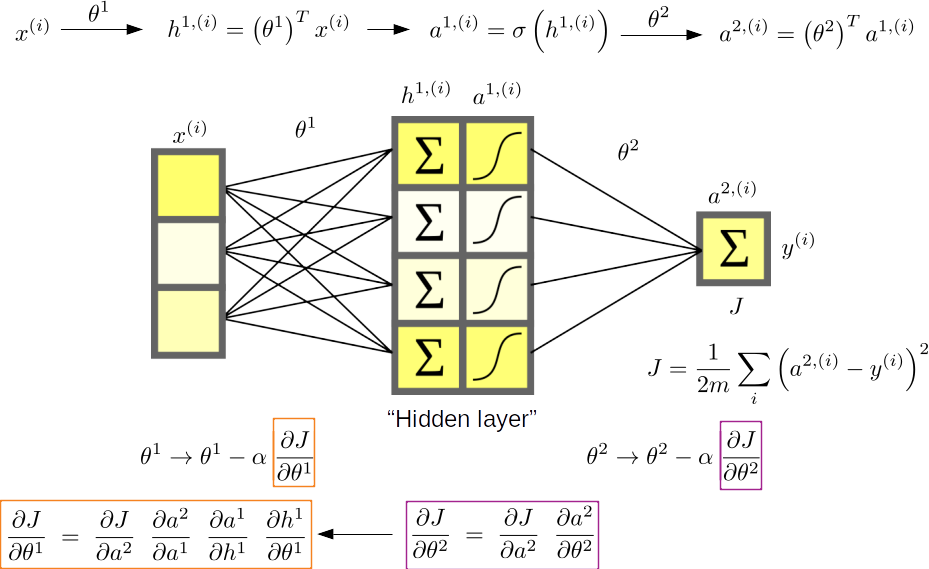
</div>
<p style="text-align:center;font-size:80%;font-style:italic">
Figure 5: Backpropagation.
</p>

For backpropagation we are still missing the one element connecting the layers, namely $\frac{\partial a^2}{\partial a^1}$:
\begin{align}
a^2 &= \Theta^2 a^1 \\
\frac{\partial a^2}{\partial a^1} &= \Theta^2
\end{align}

With this and the above derived equations we can calculated the gradient of the first (hidden) layer weights regarding the output error as:
\begin{align}
\frac{\partial J}{\partial \Theta^1} &= \underbrace{\frac{\partial J}{\partial a^2}
                                                    \frac{\partial a^2}{\partial a^1}}_\text{(a.)}
                                        \underbrace{\frac{\partial a^1}{\partial h^1}
                                                    \frac{\partial h^1}{\partial \Theta^1}}_\text{(b.)} \\
\end{align}
**The part (a.) can be calculated in the second (output) layer and is returned as upstream gradient.**

**In the first (hidden) layer we can then use this gradient and combine it with part (b.) to obtain the gradient for the weights of layer 1 with respect to the output error.**

Let's put this into work by building a feed forward network for our regression task with:

1. The 63 `mol_descriptors` as input $x^{(i)}$
2. One hidden layer $1$ with 32 neurons and a ReLu activation: `class HiddenLayer`
3. One output layer $2$ with two outputs (LUMO and HOMO) with a linear (no) activation function: `class OutputLayer`

Both have a forward pass, which calculates the output of the layer, a backward pass which calculates the gradients and an update function that updates the weights using the gradients and the learning rate.

Only the `OutputLayer` has to return the part (a.) from above to then pass it on to the backward pass of the `HiddenLayer`.

We start implementing from the bottom up with the `OutputLayer` (layer 2):


In [25]:
class OutputLayer:

    def __init__(self, n_inputs: int, n_outputs: int):
        # Initialize (n_inputs X n_outputs)-dimensional weight matrix self.theta with a
        # Glorot et Al. 2010 uniform initialization:
        self.theta = None
        # YOUR CODE HERE
        z = np.sqrt(6/(n_inputs + n_outputs))
        self.theta = np.random.uniform(-z, z, (n_inputs, n_outputs))
        
        # Initialize the bias vector self.b to zeros:
        self.b = None
        # YOUR CODE HERE
        self.b = np.zeros((n_outputs,))

    def forward(self, input_vector):
        self.input = input_vector
        # Compute the states h(x) as self.h
        self.h = None
        # YOUR CODE HERE
        self.h = (self.input @ self.theta) + self.b
        
        # As this is a linear layer a(x) = h(x)
        self.a = self.h
        return self.a
    
    def backward(self, y_predicted, y_true):
        # HINT: as we do things backwards you might have to transpose some matrices
        
        # partial derivative of the states with respect to the weights
        dh2_dtheta2 = None
        # YOUR CODE HERE
        dh2_dtheta2 = self.input # since this is the only layer
        
        # partial derivative of activations with respect to the states
        # One as we have a linear/no activation for the regression output
        da2_dh2 = 1
        
        # partial derivative of the error (MSE) with respect to the acivation
        # infer the batch size from the input shape for normalization
        dJ_da2 = None
        # YOUR CODE HERE
        m = self.input.shape[0]
        dJ_da2 = (1/m) * (y_predicted - y_true)
        
        # Gradient of the weights with respect to the error
        # for the weight updates for this layer:
        self.dJ_dTheta2 = None
        # YOUR CODE HERE
        self.dJ_dTheta2 = (dJ_da2.T * da2_dh2 @ dh2_dtheta2).T
        
        # Gradient of the bias with respect to the error
        # Recall using dh2_db2 = 1 and handle the batch size by summation
        self.dJ_db2 = None
        # YOUR CODE HERE
        # print(f"dJ_db2 (w/sum): {(dJ_da2 * da2_dh2).shape}")
        self.dJ_db2 = np.sum(dJ_da2 * da2_dh2 * 1,axis=0)
        # print(f"{self.dJ_db2.shape=}")
        
        # The downstream gradient for layer 1.
        # employing da2_da1 = theta
        downstream_gradient = None
        # YOUR CODE HERE
        downstream_gradient = dJ_da2 @ self.theta.T
        
        return downstream_gradient
        
    def update(self, learning_rate):
        # You don't need to change this
        # HINT:
        # If your model gets worse instead of better make sure you calculate the correct MSE
        self.theta = self.theta - learning_rate*self.dJ_dTheta2
        self.b = self.b - learning_rate*self.dJ_db2

In [26]:
X_sample = X_train[0:100, :]
y_sample = y_train[0:100, :]

In [27]:
# Output Forward Pass - 1 point

l2 = OutputLayer(X_sample.shape[1], y_sample.shape[1])
y_pred_sample = l2.forward(X_sample)

assert y_sample.shape[0] == y_pred_sample.shape[0]
assert y_sample.shape[1] == y_pred_sample.shape[1]

In [28]:
# Output Backward Pass - 2 points

downstream_gradient = l2.backward(y_pred_sample, y_sample)

assert downstream_gradient.shape[0] == X_sample.shape[0]
assert downstream_gradient.shape[1] == X_sample.shape[1]

In [29]:
# Output Weight Update - 2 points

l2 = OutputLayer(X_sample.shape[1], y_sample.shape[1])
y_pred_before = l2.forward(X_sample)

for i in range(100):
    y_pred_sample = l2.forward(X_sample)
    l2.backward(y_pred_sample, y_sample)
    l2.update(0.05)
    
y_pred_after = l2.forward(X_sample)
r2_before = r2_score(y_sample, y_pred_before)
r2_after = r2_score(y_sample, y_pred_after)

assert r2_before < r2_after

Next is the `HiddenLayer`. There are mainly two main differences you have to keep in mind here:
1. You have to work with the ReLu activation, so $\frac{\partial a}{\partial h}$ isn't $1$ anymore.
2. We use the `upstream_gradient` for the backward pass, provided by the `backward` method of the `OutputLayer`.

In [30]:
class HiddenLayer:

    def __init__(self, n_inputs: int, n_outputs: int):
        # Initialize the weight matrix self.theta with a
        # Glorot et Al. 2010 uniform initialization:
        self.theta = None
        # YOUR CODE HERE
        z = np.sqrt(6/(n_inputs + n_outputs))
        self.theta = np.random.uniform(-z, z, (n_inputs, n_outputs))
        
        # Initialize the bias vector to zeros:
        self.b = None
        # YOUR CODE HERE
        self.b = np.zeros((n_outputs,))

    def forward(self, input_vector):
        self.input = input_vector
        # Compute the states h(x) as self.h
        self.h = None
        # YOUR CODE HERE
        # print(f"{self.input.shape=}\n{self.theta.shape=}\n{self.b.shape=}\n---------")
        self.h = (self.input @ self.theta) + self.b
        
        # Compute the activations a(x) as self.a with ReLu activation
        self.a = None
        # YOUR CODE HERE
        self.a = self.h
        self.a[self.a <= 0] = 0
        
        return self.a
    
    def backward(self, upstream_gradient):
        # HINT: as we do things backwards you might have to transpose some matrices
        
        # Gradient of the states with respect to the inputs (trivial):
        dh1_dtheta1 = None
        # YOUR CODE HERE
        dh1_dtheta1 = self.input
        
        # Gradient of the activations with respect to the states:
        # Remember to apply ReLu here
        da1_dh1 = None
        # YOUR CODE HERE
        da1_dh1 = self.a > 0
        
        # Gradient of the error with respect to the weights:
        # Now we can finally use the upstream gradient...
        self.dJ_dTheta1 = None
        # YOUR CODE HERE
        self.dJ_dTheta1 = ((upstream_gradient * da1_dh1).T @ dh1_dtheta1).T
        
        # And for the bias, similar to the output layer but this time
        # using the upstream gradient:
        self.dJ_db1 = None
        # YOUR CODE HERE
        self.dJ_db1 = np.sum(upstream_gradient * da1_dh1 * 1, axis=0)
        
    def update(self, learning_rate):
        # You don't need to change this
        self.theta = self.theta - learning_rate*self.dJ_dTheta1
        self.b = self.b - learning_rate*self.dJ_db1

In [31]:
# We create a sample from the existing data that matches the output dimension 
# and also shift it above zero, so it is learnable with ReLu:

n_hidden = 32

X_sample = X_train[0:100, :]
y_sample = np.array([y_train[i*100:i*100+100, 0] for i in range(n_hidden)]).T
y_sample = y_sample-y_sample.min()

In [32]:
# Hidden Forward Pass - 1 point

l1 = HiddenLayer(X_sample.shape[1], n_hidden)

y_pred_sample = l1.forward(X_sample)
assert y_pred_sample.shape[0] == X_sample.shape[0]
assert y_pred_sample.shape[1] == n_hidden
assert y_pred_sample.min() >= 0

In [33]:
# Hidden Weight Update - 2 points

l1 = HiddenLayer(X_sample.shape[1], n_hidden)
y_pred_before = l1.forward(X_sample)

for i in range(100):
    y_pred_sample = l1.forward(X_sample)
    downstream_gradient = 1/100 * (y_pred_sample-y_sample)
    l1.backward(downstream_gradient)
    l1.update(0.05)
    
y_pred_after = l1.forward(X_sample)
r2_before = r2_score(y_sample, y_pred_before)
r2_after = r2_score(y_sample, y_pred_after)

assert r2_before < r2_after

## NN Training

Okay now let's see whether we can be better with our network than the benchmark ridge regression.

As said before we will train our network in batches (`batch_size`) and for `n_epochs`.  
Per epoch we therefore have to pass `X_train.shape[0] // batch_size` batches.  
For each epoch we randomly shuffle the dataset. Using `np.random.permutation(X_train.shape[0])` we generate a randomly shuffled index. Indexing X and y with slices of this shuffled index, creates differently shuffled batches for each epoch.

In [34]:
n_hidden = 64
lr = 0.05
n_epochs = 60
batch_size = 100
n_batches = X_train.shape[0] // batch_size

l1 = HiddenLayer(X_train.shape[1], n_hidden)
l2 = OutputLayer(n_hidden, y_train.shape[1])

y_pred_before = l2.forward(l1.forward(X_test))

In [35]:
for epoch in range(n_epochs):
    permutation = np.random.permutation(X_train.shape[0])
    
    for batch in range(n_batches):
        start = batch*batch_size
        end = start+batch_size
        X_batch = X_train[permutation[start:end]]
        y_batch = y_train[permutation[start:end]]
        
        # Get the predictions
        y_pred = None
        # YOUR CODE HERE
        y_pred_l1 = l1.forward(X_batch)
        y_pred = l2.forward(y_pred_l1)
        
        # Do the backward pass of both layers and update the weights
        # YOUR CODE HERE
        l2_update = l2.backward(y_pred, y_batch)
        l2.update(lr)
        l1.backward(l2_update)
        l1.update(lr)
        
    print(f"{X_test.shape=}")
    y_pred = l2.forward(l1.forward(X_test))
    if epoch%4 == 0:
        print(f"Epoch {epoch}: Test R2 = {r2_score(y_test, y_pred)}")
    

X_test.shape=(40998, 63)
Epoch 0: Test R2 = 0.12048248304452902
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 4: Test R2 = 0.6654485391890625
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 8: Test R2 = 0.7333898033711397
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 12: Test R2 = 0.7664747806166414
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 16: Test R2 = 0.772303725173398
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 20: Test R2 = 0.7838827346778954
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch 24: Test R2 = 0.7975505721723772
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
X_test.shape=(40998, 63)
Epoch

In [36]:
# Full Training - 2 points

y_pred_after = l2.forward(l1.forward(X_test))

r2_before = r2_score(y_test, y_pred_before)
r2_after = r2_score(y_test, y_pred_after)

assert r2_before < r2_after

In [37]:
y_pred = l2.forward(l1.forward(X_test))

r2_lumo_nn = r2_score(y_test[:,0], y_pred[:,0])
r2_homo_nn = r2_score(y_test[:,1], y_pred[:,1])
print(f'R2 LUMO: {r2_lumo_nn}\nR2 HOMO: {r2_homo_nn}')

R2 LUMO: 0.7684237299943314
R2 HOMO: 0.8633124643072982


In [38]:
# Bonus Beating Ridge - 1 point

print(f'\tRidge\t\t\tNN\nLUMO\t{r2_lumo_ridge}\t{r2_lumo_nn}\nHOMO\t{r2_homo_ridge}\t{r2_homo_nn}')

assert r2_lumo_nn > r2_lumo_ridge and r2_homo_nn > r2_homo_ridge

	Ridge			NN
LUMO	0.716582985383903	0.7684237299943314
HOMO	0.7971295175598255	0.8633124643072982


Quite possibly you were able to beat the ridge regression at that point, only with one hidden ReLu layer. Of course the hyperparameters of both models haven't been optimized yet, so you can get even better. But please do this in a separate notebook ;)

Let's have a look at the final plots:

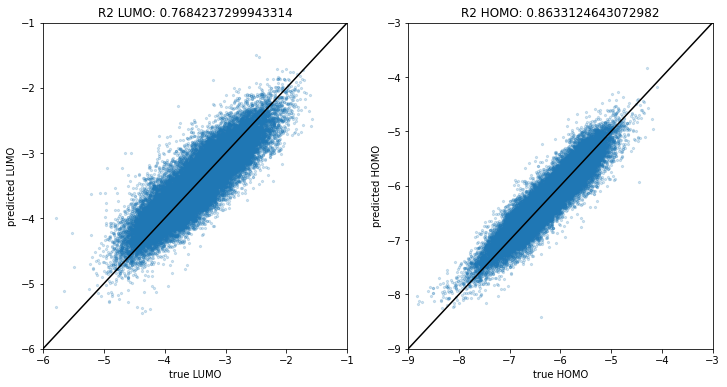

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].scatter(y_test[:,0], y_pred[:,0], alpha=0.2, s=5)
axs[0].plot([-6, -1], [-6, -1], 'k')
axs[0].set_title(f'R2 LUMO: {r2_lumo_nn}')
axs[0].set_xlabel('true LUMO')
axs[0].set_ylabel('predicted LUMO')
axs[0].set_xlim([-6, -1])
axs[0].set_ylim([-6, -1])

axs[1].scatter(y_test[:,1], y_pred[:,1], alpha=0.2, s=5)
axs[1].plot([-9, -3], [-9, -3], 'k')
axs[1].set_title(f'R2 HOMO: {r2_homo_nn}')
axs[1].set_xlabel('true HOMO')
axs[1].set_ylabel('predicted HOMO')
axs[1].set_xlim([-9, -3])
axs[1].set_ylim([-9, -3])

plt.show()

**You finished the Exercise!**

Next time we will start using Tensorflow and Keras to build neural networks.  

Here is a little example for our application. Be aware that Tensorflow does things slightly different internally, so it might give results that differ from your own implementation.

You can use this example as a start to experiment with own implementations **in another notebook**:

Model: "simple_ff"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4096      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,226
Trainable params: 4,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
103/103 [==============================] - 1s 3ms/step - loss: 2.1033 - MSE: 2.1033
Epoch 2/5
103/103 [==============================] - 0s 1ms/step - loss: 0.4976 - MSE: 0.4976
Epoch 3/5
103/103 [==============================] - 0s 2ms/step - loss: 0.3676 - MSE: 0.3676
Epoch 4/5
103/103 [==============================] - 0s 1ms/step - loss: 0.3002 - MSE: 0.3002
Epoc

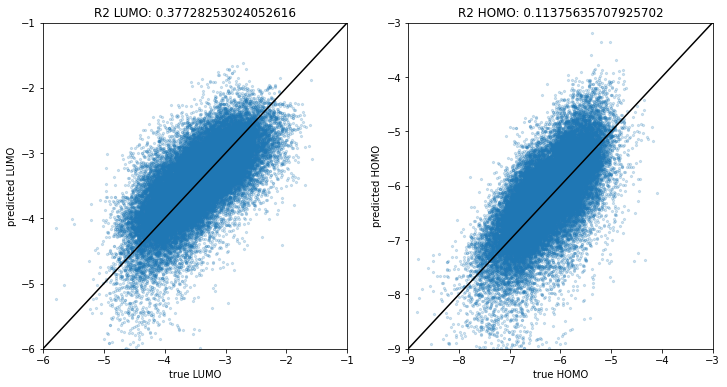

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

n_hidden = 64
lr = 0.05
# A low number of epochs so the nb doesn't slow down during grading
n_epochs = 5
batch_size = 100

inputs = keras.Input(shape=(X.shape[1],))
hidden1 = layers.Dense(n_hidden, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(hidden1)
model = keras.Model(inputs=inputs, outputs=outputs, name="simple_ff")
print(model.summary())

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(),
    metrics=["MSE"],
)

model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs)

y_pred = model.predict(X_test)
r2_lumo_keras = r2_score(y_test[:,0], y_pred[:,0])
r2_homo_keras = r2_score(y_test[:,1], y_pred[:,1])
print(f'R2 LUMO: {r2_lumo_keras}\nR2 HOMO: {r2_homo_keras}')

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].scatter(y_test[:,0], y_pred[:,0], alpha=0.2, s=5)
axs[0].plot([-6, -1], [-6, -1], 'k')
axs[0].set_title(f'R2 LUMO: {r2_lumo_keras}')
axs[0].set_xlabel('true LUMO')
axs[0].set_ylabel('predicted LUMO')
axs[0].set_xlim([-6, -1])
axs[0].set_ylim([-6, -1])

axs[1].scatter(y_test[:,1], y_pred[:,1], alpha=0.2, s=5)
axs[1].plot([-9, -3], [-9, -3], 'k')
axs[1].set_title(f'R2 HOMO: {r2_homo_keras}')
axs[1].set_xlabel('true HOMO')
axs[1].set_ylabel('predicted HOMO')
axs[1].set_xlim([-9, -3])
axs[1].set_ylim([-9, -3])

plt.show()